# **Дополнительное домашнее задание. Логистическая регрессия и решающие деревья**

Суммарно 10 баллов за всю работу. По 5 баллов в каждой части.

Требуется выполнить следующие задания.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random

from __future__ import annotations

## **Часть 1. Логистическая регрессия (5 баллов)**

**Задание 1 (3 балла)**. Реализуйте логистическую регрессию, обучаемую с помощью двух видов градиенткого спуска:
- полный (по всем данным) градиентный спуск;

- стохастический градиентный спуск;

Во всех пунктах необходимо соблюдать два условия:
- Циклы можно использовать только для итераций градиентного спуска.
- В качестве критерия останова необходимо использовать (одновременно):

    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка 1e-6), задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, добавьте атрибут класса `loss_history`. В нем после вызова метода `fit` должны содержаться значения функции потерь для всех итераций градиентного спуска, начиная с нулевой.

Инициализировать веса можно случайным образом или нулевым вектором.

In [2]:
from sklearn.base import BaseEstimator

from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc

from sklearn.model_selection import KFold

In [20]:
class MyLogisticRegression(BaseEstimator):
    def __init__(self, gd_type: str = 'stochastic', tolerance: float = 1e-6,
                 max_iter: int = 1000, eta: float = 1e-2,
                 w0: np.array = None) -> None:
        """
        Аргументы:
          gd_type: вид градиентного спуска ('full' или 'stochastic').

          tolerance: порог для остановки градиетного спуска.

          max_iter: максимальное количество шагов в градиентном спуске.

          eta: скорость обучения (learning rate).

          w0: массив размерности d (d — количество весов в оптимизации).
              Начальные веса.
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None


    def fit(self, X: np.array, y: np.array) -> MyLogisticRegression:
        """Обучаем модель на training данных. Сохраняйте значении функции потерь после каждой итерации.

        Аргументы:
          X: данные на обучение.

          y: целевая переменная.

        Возвращает:
          self: обученный регрессор.
        """
        self.loss_history = []
        # your code
        n_samples, n_features = X.shape
    
        # Initialize weights with bias term
        if self.w0 is None:
            self.w = np.zeros(n_features + 1)  # +1 for bias term
        else:
            self.w = self.w0.copy()

        # Add bias term to X
        X = np.hstack([np.ones((n_samples, 1)), X])

        # Gradient descent loop
        for iteration in range(self.max_iter):
            # Compute gradient
            if self.gd_type == 'full':
                gradient = self.calc_gradient(X, y)
            elif self.gd_type == 'stochastic':
                idx = np.random.randint(0, n_samples)
                gradient = self.calc_gradient(X[idx:idx+1], y[idx:idx+1])
            else:
                raise ValueError("gd_type must be 'full' or 'stochastic'")
            
            # Update weights
            new_w = self.w - self.eta * gradient
            
            # Compute loss and store it
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)

            # Check stopping criteria
            if np.linalg.norm(new_w - self.w) < self.tolerance:
                break

            self.w = new_w
        return self


    def predict_proba(self, X: np.array) -> np.array:
        """Вычислите вероятности положительного и отрицательного классов для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n, 2).
             Предсказанные вероятности.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        
        logits = X @ self.w
        probs_positive = 1 / (1 + np.exp(-logits))
        probs_negative = 1 - probs_positive
        
        return np.vstack([probs_negative, probs_positive]).T


    def predict(self, X: np.array) -> np.array:
        """Предсказание метки класса для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n,).
             Предсказанные метки классов.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        # your code
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        
        logits = X @ self.w
        return (logits >= 0).astype(int)


    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """Вычислите градиент функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d), n может быть равно 1, если выбран 'stochastic'.
          y: массив размером (n,).

        Возвращает:
          Массив размером (d,).
          Градиент функции потерь после текущей итерации.
        """
        # your code
        n_samples = X.shape[0]
        logits = X @ self.w
        predictions = 1 / (1 + np.exp(-logits))
        gradient = (X.T @ (predictions - y)) / n_samples
        return gradient


    def calc_loss(self, X: np.array, y: np.array) -> float:
        """Вычислите значение функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d).
          y: массив размером (n,).

        Возвращает:
          Значение функции потерь после текущей итерации.
        """
        logits = X @ self.w
        predictions = 1 / (1 + np.exp(-logits))
        loss = -np.mean(y * np.log(predictions + 1e-15) + (1 - y) * np.log(1 - predictions + 1e-15))
        return loss

Далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

Сгенерируем искусственные данные.

In [21]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=999)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=999)

**Задание 2 (1 балл).** Обучите логистическую регрессию на искусственных данных. Нарисуйте изменение лосса во время обучения.

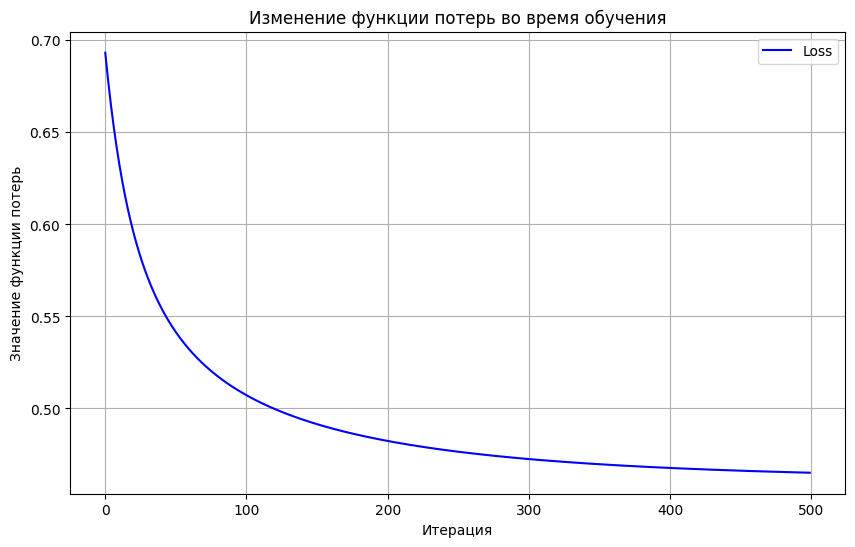

In [22]:
import matplotlib.pyplot as plt

# Создаем экземпляр модели логистической регрессии
model = MyLogisticRegression(
    gd_type='full',  # Используем полный градиентный спуск
    eta=0.01,        # Скорость обучения
    max_iter=500,    # Максимальное количество итераций
    tolerance=1e-6   # Порог для остановки
)

# Обучаем модель
model.fit(X_train, y_train)

# Получаем историю изменения лосса
loss_history = model.loss_history

# Визуализируем изменение лосса
plt.figure(figsize=(10, 6))
plt.plot(range(len(loss_history)), loss_history, label="Loss", color="blue")
plt.title("Изменение функции потерь во время обучения")
plt.xlabel("Итерация")
plt.ylabel("Значение функции потерь")
plt.grid(True)
plt.legend()
plt.show()

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC- и PR-кривые.

ROC-AUC: 0.8580
PR-AUC: 0.8189


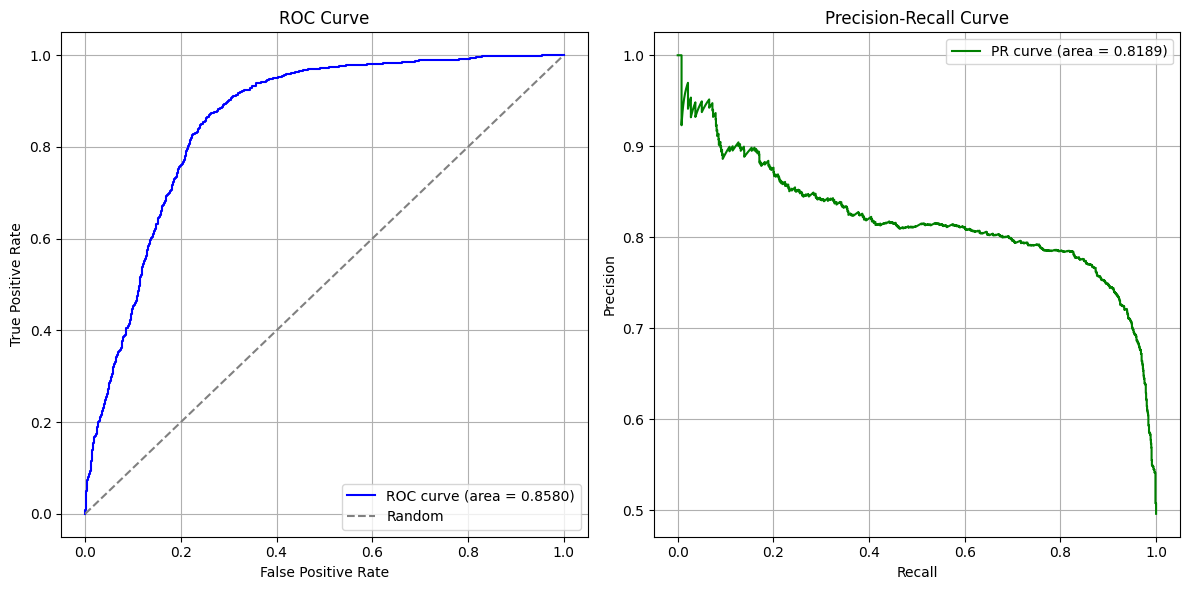

In [23]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt

probs = model.predict_proba(X_test)[:, 1]  # Вероятности положительного класса

# Вычисляем ROC-AUC
roc_auc = roc_auc_score(y_test, probs)
print(f"ROC-AUC: {roc_auc:.4f}")

# Вычисляем PR-AUC
precision, recall, _ = precision_recall_curve(y_test, probs)
pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.4f}")

# Строим ROC-кривую
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(12, 6))

# ROC-кривая
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.4f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

# PR-кривая
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"PR curve (area = {pr_auc:.4f})", color="green")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Задание 3 (1 балл).** Оцените ошибку ROC-AUC и PR-AUC вашей модели при помощи K-fold кросс-валидации.  

In [24]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=999)

roc_auc_scores = []
pr_auc_scores = []

for train_index, test_index in kf.split(X):
    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Обучаем модель
    model = MyLogisticRegression(
        gd_type='full',
        eta=0.01,
        max_iter=500,
        tolerance=1e-6
    )
    model.fit(X_train, y_train)
    
    # Предсказываем вероятности
    probs = model.predict_proba(X_test)[:, 1]
    
    # Вычисляем ROC-AUC
    roc_auc = roc_auc_score(y_test, probs)
    roc_auc_scores.append(roc_auc)
    
    # Вычисляем PR-AUC
    precision, recall, _ = precision_recall_curve(y_test, probs)
    pr_auc = auc(recall, precision)
    pr_auc_scores.append(pr_auc)


print(f"Среднее значение ROC-AUC: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")
print(f"Среднее значение PR-AUC: {np.mean(pr_auc_scores):.4f} ± {np.std(pr_auc_scores):.4f}")

Среднее значение ROC-AUC: 0.8605 ± 0.0035
Среднее значение PR-AUC: 0.8320 ± 0.0075


## **Часть 2. Решающие деревья (5 баллов)**

Здесь требуется реализовать разбиение элементов выборки в вершине дерева.

$R_m$ — множество объектов в разбиваемой вершине, $j$ — номер признака, по которому происходит разбиение, $t$ — порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ — множество объектов в левом поддереве, $R_r$ — множество объектов в правом поддереве.

$H(R)$ — критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

In [8]:
from typing import Iterable, List, Tuple

Так как Boston Dataset с недавних пор отсутствует в sklearn, то ниже реализован способ загрузки данного датасета из другого источника.

In [9]:
# `load_boston` has been removed from scikit-learn since version 1.2.

#from sklearn.datasets import load_boston
#boston = load_boston()

In [26]:
!wget -i https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/data/boston_house_prices.csv
data_git = pd.read_csv('boston_house_prices.csv', sep="\s+")

zsh:1: command not found: wget


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/1s/5zrmnc61429fjndvw10l0mb80000gn/T/ipykernel_60258/2464913690.py:2: SyntaxWarning: invalid escape sequence '\s'
  data_git = pd.read_csv('boston_house_prices.csv', sep="\s+")


**Data Set Characteristics:**  

    :Number of Instances: 506

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
.. topic:: References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.



In [11]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/1s/5zrmnc61429fjndvw10l0mb80000gn/T/ipykernel_60258/16828617.py:2: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


In [12]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

X = pd.DataFrame(data, columns=feature_names, index=range(len(data)))
y = pd.DataFrame(target, columns=['MEDV'], index=range(len(target)))

X['target'] = y

In [13]:
X_train, X_test = train_test_split(X, test_size=0.25, random_state=999)

**Задание 1 (1 балл)**. Реализуйте подсчет критерия ошибки. Для этого реализуйте функции для подсчета значения критерия информативности, а также для разбиения вершины.

In [27]:
def H(R: np.array) -> float:
    """
    Вычислить критерий информативности (impurity criterion) для фиксированного набора объектов R.
    Предполагается, что последний столбец содержить целевую переменную.
    """
    y = R[:, -1]  # Целевая переменная (последний столбец)
    if len(y) == 0:
        return 0.0
    mean_y = np.mean(y)
    variance = np.mean((y - mean_y) ** 2)
    return variance


def split_node(R_m: np.array, feature: str, t: float) -> Iterable[np.array]:
    """
    Разделить фиксированный набор объектов R_m с заданным признаком (номером признака) и пороговым значением t.
    """
    mask = R_m[:, feature] <= t  # Маска для разделения
    R_ell = R_m[mask]           # Левое поддерево
    R_r = R_m[~mask]            # Правое поддерево
    return R_ell, R_r


def q_error(R_m: np.array, feature: str, t: float) -> float:
    """
    Вычислить критерий ошибки для заданных параметров разделения.
    """
    R_ell, R_r = split_node(R_m, feature, t)
    
    # Размеры подмножеств
    n_m = len(R_m)
    n_ell = len(R_ell)
    n_r = len(R_r)
    
    # Критерий информативности для подмножеств
    H_ell = H(R_ell)
    H_r = H(R_r)
    
    # Вычисление критерия ошибки
    Q = (n_ell / n_m) * H_ell + (n_r / n_m) * H_r
    return Q


**Задание 2 (1 балл)**. Переберите все возможные разбиения обучающей выборки по одному из признаков и постройте график критерия ошибки в зависимости от значения порога.

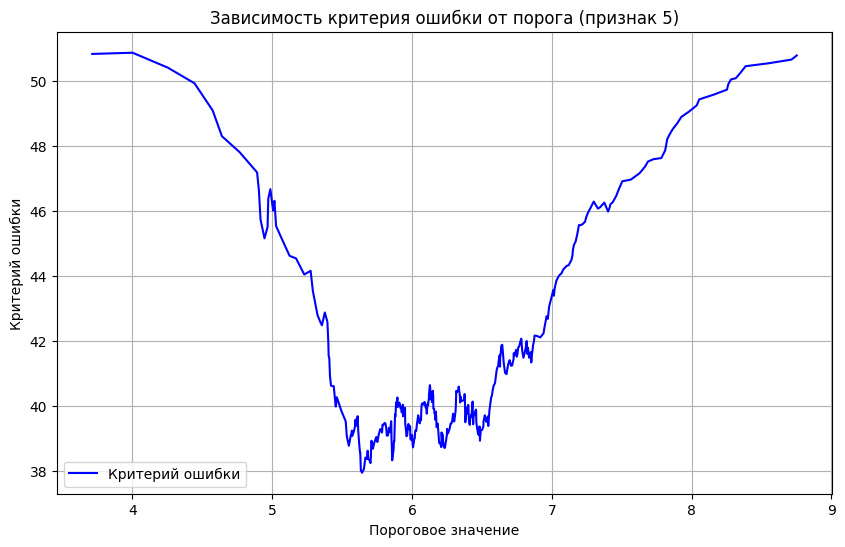

In [30]:
def plot_error_vs_threshold(R_m: np.array, feature: int):

    # Получаем уникальные значения признака, отсортированные по возрастанию
    feature_values = np.sort(np.unique(R_m[:, feature]))
    
    # Вычисляем пороги как средние значения между соседними уникальными значениями
    thresholds = (feature_values[:-1] + feature_values[1:]) / 2
    
    # Вычисляем критерий ошибки для каждого порога
    errors = [q_error(R_m, feature, t) for t in thresholds]
    
    # Строим график
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, errors, label="Критерий ошибки", color="blue")
    plt.title(f"Зависимость критерия ошибки от порога (признак {feature})")
    plt.xlabel("Пороговое значение")
    plt.ylabel("Критерий ошибки")
    plt.grid(True)
    plt.legend()
    plt.show()

# Строим график зависимости критерия ошибки от порога
feature_index = 5
plot_error_vs_threshold(data, feature_index)

**Задание 3  (1 балл)**. Напишите функцию, находящую оптимальное разбиение данной вершины по данному признаку.

In [31]:
def get_optimal_split(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
        # Получаем уникальные значения признака, отсортированные по возрастанию
    feature_values = np.sort(np.unique(R_m[:, feature]))
    
    # Вычисляем пороги как средние значения между соседними уникальными значениями
    thresholds = (feature_values[:-1] + feature_values[1:]) / 2
    
    # Вычисляем критерий ошибки для каждого порога
    errors = [q_error(R_m, feature, t) for t in thresholds]
    
    # Находим минимальное значение критерия ошибки и соответствующий порог
    minimal_error = min(errors)
    optimal_threshold = thresholds[np.argmin(errors)]
    
    return optimal_threshold, minimal_error

**Задание 4  (1 балл)**. Для первого разбиения найдите признак, показывающий наилучшее качество. Каков порог разбиения и значение качества? Постройте график критерия ошибки для данного признака в зависимости от значения порога.

Лучший признак: 2
Оптимальный порог: 7.6250
Минимальная ошибка: 33.0732


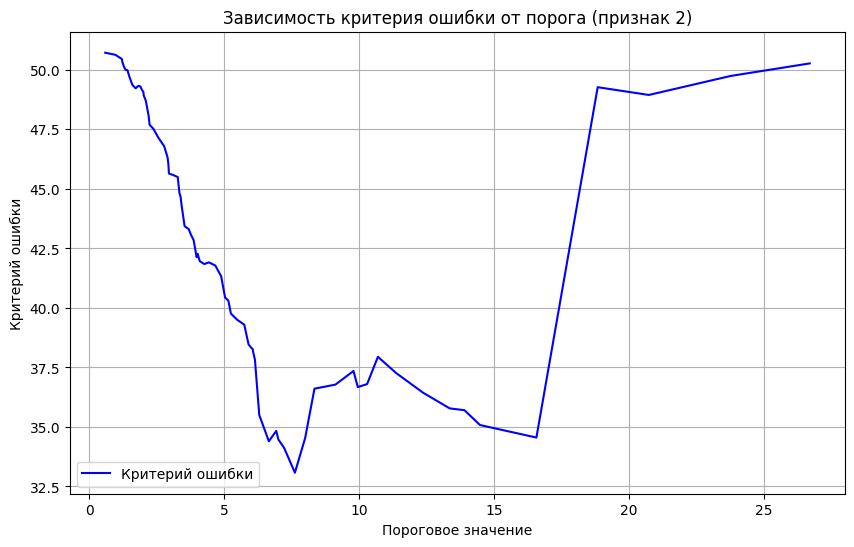

In [33]:
def find_best_feature_and_split(R_m: np.array) -> Tuple[int, float, float]:

    n_features = R_m.shape[1] - 1  # Количество признаков (без целевой переменной)
    best_feature = None
    best_threshold = None
    best_error = float('inf')  # Инициализируем бесконечностью
    
    # Перебираем все признаки
    for feature in range(n_features):
        threshold, error = get_optimal_split(R_m, feature)
        if error < best_error:
            best_feature = feature
            best_threshold = threshold
            best_error = error
    
    return best_feature, best_threshold, best_error



# Находим лучший признак и его оптимальное разбиение
best_feature, best_threshold, best_error = find_best_feature_and_split(data)

print(f"Лучший признак: {best_feature}")
print(f"Оптимальный порог: {best_threshold:.4f}")
print(f"Минимальная ошибка: {best_error:.4f}")

# Строим график для лучшего признака
plot_error_vs_threshold(data, best_feature)

 **Задание 5 (1 балл)**. Изобразите разбиение визуально. Для этого постройте диаграмму рассеяния целевой переменной в зависимости от значения входного признака. Далее изобразите вертикальную линию, соответствующую порогу разбиения.

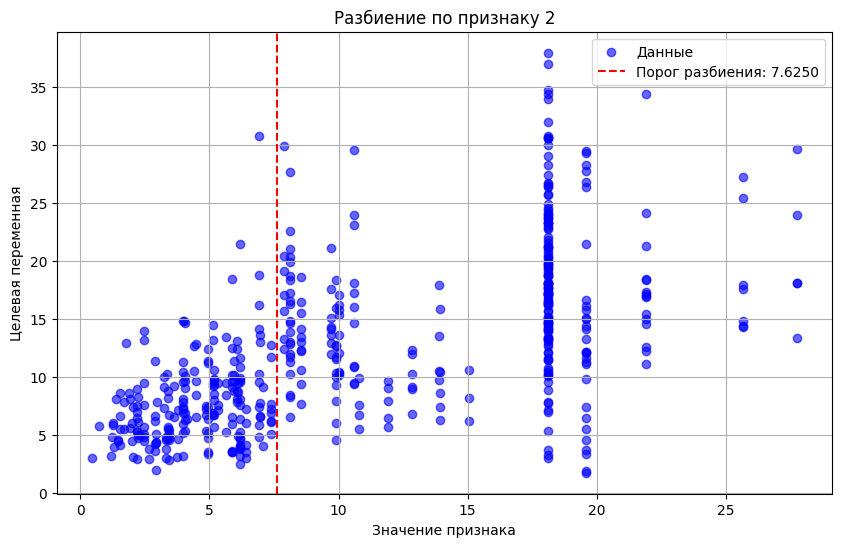

In [35]:
def visualize_split(R_m: np.array, feature: int, threshold: float):

    # Извлекаем значения признака и целевой переменной
    feature_values = R_m[:, feature]
    target_values = R_m[:, -1]
    
    # Строим диаграмму рассеяния
    plt.figure(figsize=(10, 6))
    plt.scatter(feature_values, target_values, color="blue", alpha=0.6, label="Данные")
    
    # Добавляем вертикальную линию для порога разбиения
    plt.axvline(x=threshold, color="red", linestyle="--", label=f"Порог разбиения: {threshold:.4f}")
    
    # Настройка графика
    plt.title(f"Разбиение по признаку {feature}")
    plt.xlabel("Значение признака")
    plt.ylabel("Целевая переменная")
    plt.legend()
    plt.grid(True)
    plt.show()
    
visualize_split(data, best_feature, best_threshold)